In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from matplotlib import cm


## Setup

In [2]:
# put ipynb beside MLPC2025_classification in dir
MLPC2025_classification = Path.cwd() / "MLPC2025_classification"

labels_dir = MLPC2025_classification / "labels"                   # These are your targets Y for classifiers - 58 keys (class names), each mapped to a (frames × annotators) array == annotations categories?
audio_features_dir = MLPC2025_classification / "audio_features"   # These are your input X for classifiers (e.g. MFCC, ZCR, chroma)
audio_mp3_dir = MLPC2025_classification / "audio"

annotations_path = MLPC2025_classification / "annotations.csv"
metadata_path = MLPC2025_classification / "metadata.csv"


annotations_df = pd.read_csv(annotations_path)
metadata_df = pd.read_csv(metadata_path)

### metadata df

In [3]:
metadata_df

,filename,keywords,freesound_id,sound_link,manufacturer,license,title,description,num_downloads,geotag,start_time_s,end_time_s
0,321771.mp3,"Interior, AMB, Italy, Distant, Speech, Reverb",321771,https://freesound.org/people/Skjor1/sounds/321...,Skjor1,http://creativecommons.org/publicdomain/zero/1.0/,Interior Ambience + Distant Reverberant Speech...,Interior Ambience + Distant Reverberant Speech...,120,NaN,5.200,27.179
1,451371.mp3,"kids, throaty, crowd, India, distant, traffic,...",451371,https://freesound.org/people/kyles/sounds/451371/,kyles,http://creativecommons.org/publicdomain/zero/1.0/,election rally crowd and speech with distant t...,election rally crowd and speech with distant t...,122,NaN,120.800,144.984
2,199414.mp3,"broadcast, speech, radio",199414,https://freesound.org/people/martinimeniscus/s...,martinimeniscus,http://creativecommons.org/publicdomain/zero/1.0/,"Old Radio Speech Background, higher FF125.aif",Background noise for an old radio broadcast sp...,391,NaN,102.003,130.921
3,410952.mp3,"loop2017, atmos, dolby, speech, ableton",410952,https://freesound.org/people/lietoofine/sounds...,lietoofine,https://creativecommons.org/licenses/by/4.0/,dolby atmos speech.wav,dolby atmos speech @Loop2017,193,52.479543 13.500279,31.330,54.021
4,203908.mp3,"dr-40, project, speech, student, italian, reci...",203908,https://freesound.org/people/s9ames/sounds/203...,s9ames,http://creativecommons.org/licenses/by/3.0/,bologna speech Italian2,recorded with a tascam dr-40 in a sound studio...,526,NaN,29.200,45.689
...,...,...,...,...,...,...,...,...,...,...,...,...
8225,505984.mp3,"droplets, several-drops, dripping, liquid-drip...",505984,https://freesound.org/people/Perplessio/sounds...,Perplessio,http://creativecommons.org/publicdomain/zero/1.0/,Droplets underwater (multiplied).wav,"Droplets falling on a water surface, recorded ...",138,NaN,0.000,16.960
8226,428889.mp3,"tin, patter, rain, roof",428889,https://freesound.org/people/moviebuffgavin/so...,moviebuffgavin,http://creativecommons.org/publicdomain/zero/1.0/,Rain Droplets on Tin Roof,The sound of water droplets from trees and suc...,278,NaN,12.400,36.251
8227,575816.mp3,"raining, tone, upstairs, house, hearing, gener...",575816,https://freesound.org/people/Iceofdoom/sounds/...,Iceofdoom,https://creativecommons.org/licenses/by/4.0/,Upstairs Apartment - Rain Ambience (3 minutes)...,My buddy finds solace in listening to the rain...,213,NaN,55.421,80.704
8228,174501.mp3,"atmosphere, blowing, air, whistle, weather, wind",174501,https://freesound.org/people/unfa/sounds/174501/,unfa,http://creativecommons.org/publicdomain/zero/1.0/,Window Wind,It's a sound of wind blowing through a shut (b...,861,NaN,15.200,33.771


### annotations df

In [4]:
annotations_df

,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
0,161976549,117126.mp3,1.145580e+77,An alarm is ringing loudly and repeatedly nearby.,0.000000,10.503064,345.033,Raw loud alarm sound repeatedly ringing nearby,['Alarm']
1,161976549,117126.mp3,1.145580e+77,An alarm is ringing repeatedly nearby.,12.514615,23.048000,345.033,Clean alarm sound repeatedly ringing nearby,['Alarm']
2,161976550,118234.mp3,5.022630e+76,An alarm clock is beeping continuously.,0.000000,13.414880,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
3,161976550,118234.mp3,5.022630e+76,An alarm clock is beeping continuously.,15.134252,28.492000,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
4,161976551,119173.mp3,8.105080e+76,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']"
...,...,...,...,...,...,...,...,...,...
27547,161993076,95067.mp3,3.151260e+76,A train car screeches loudly.,2.349007,4.698014,470.426,A train car screeching loudly.,['Train']
27548,161993076,95067.mp3,3.151260e+76,A train car screeches loudly.,7.889899,8.580784,470.426,A train car screeching loudly.,['Train']
27549,161993076,95067.mp3,3.151260e+76,A train car screeches loudly.,13.016261,14.536207,470.426,A train car screeching loudly.,['Train']
27550,161993076,95067.mp3,3.151260e+76,A diesel truck engine is idling continuously.,0.000000,15.890000,470.426,A diesel truck engine idling continuously.,['Truck']


### Category frequency

In [5]:
# category counts

raw_categories = annotations_df['categories'].dropna().to_list()
# str to list
all_cats = [eval(row) for row in raw_categories]
# flatten
categories = [cat for sublist in all_cats for cat in sublist]
# category counts
df = pd.DataFrame(categories, columns=['category'])
category_counts = df.value_counts().reset_index(name='count')
display(category_counts)

,category,count
0,Bird Chirp,2956
1,Speech,2664
2,Dog Bark,1446
3,Car,1266
4,Wind,1146
5,Bell,960
6,Insect Buzz,884
7,Rain,835
8,Beep/Bleep,829
9,Footsteps,798


## 1. a) Label Accuracy
Assess how accurately the applied labeling functions capture the intended classes. 
  - Do the mapped classes correspond well to the free-text annotations? 
  - Are the labeled events clearly audible within the indicated time regions?

In [6]:
# pick files and categories
annotation_categories = ['Bird Chirp', 'Dog Bark', 'Car']

def get_file_ids(category: str, k=5) -> List:
    """
    :param category: annotations_df['category'] e.g. 'Bird Chirp'
    :param k: number of mp3s to get
    :return: ['mp3name', ...]
    """
    print(f'\nGetting {k} ids for {category}')
    cat_df = annotations_df[annotations_df['categories'].dropna().apply(lambda x: category in eval(x))]
    
    mp3s = cat_df['filename'].drop_duplicates().to_list()[:k]
    ids = [f.replace('.mp3', '') for f in mp3s]

    display(cat_df.head(k+5))
    print(f'\{k} ids for {category}: {ids}')

    return ids


sample = {}
for cat in annotation_categories:
    sample[cat] = get_file_ids(cat)


Getting 5 ids for Bird Chirp


,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
82,161976583,187587.mp3,1.073750e+77,Multiple birds chirp.,0.000000,20.271995,390.999,multiple birds chirping in the background,['Bird Chirp']
99,161976596,238082.mp3,5.661940e+76,A bird sings repeatedly.,3.823445,15.726621,692.531,A bird singing repeatedly,['Bird Chirp']
302,161976700,633992.mp3,9.569620e+76,Birds chirping.,2.342489,3.717895,12141.751,birds chirping,['Bird Chirp']
303,161976700,633992.mp3,9.569620e+76,Birds chirping.,8.553307,10.079148,12141.751,birds chirping,['Bird Chirp']
409,161976741,751139.mp3,1.068040e+77,A blackbird chirps constantly.,0.000000,27.977574,226.097,a blackbird is chirping constantly,['Bird Chirp']
412,161976745,772969.mp3,1.078010e+77,Birds singing softly.,0.000000,3.725730,919.920,Muffled singing of birds,"['Bird Chirp', 'Singing']"
440,161976767,140861.mp3,1.002450e+77,Two glass materials collide with a chirping so...,1.592288,1.799078,43855.485,chirping sound of two glass materials colliding,['Bird Chirp']
577,161976825,334617.mp3,1.002450e+77,"An alien-like, echoing, digital screeching and...",0.114569,5.699830,2149.357,alien-like freaky sci-fi echoing digital scree...,"['Beep/Bleep', 'Bird Chirp']"
658,161976880,543822.mp3,3.151260e+76,Birds singing melodically.,0.000000,22.981995,1552.741,Birds melodically singing outside the station.,"['Bird Chirp', 'Singing']"
687,161976903,649341.mp3,1.087280e+75,Birds chirping repeatedly outdoors.,0.033264,19.176000,1515.195,Birds repeatedly chirping outdoors,['Bird Chirp']


\5 ids for Bird Chirp: ['187587', '238082', '633992', '751139', '772969']

Getting 5 ids for Dog Bark


,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
310,161976703,656758.mp3,7.675050e+76,A dog barks softly and intermittently in the d...,21.624837,25.020644,2340.686,"Distant dog barking — soft, intermittent, and ...",['Dog Bark']
542,161976802,207135.mp3,1.153710e+77,A dog barks in the background.,3.627170,5.031809,1222.794,A dog barks in the background,['Dog Bark']
882,161976948,118101.mp3,1.878280e+76,"The doorbell rings, and a dog barks and moves ...",0.046667,6.930000,1252.822,""" The doorbell rings"" and ""the dog reacts by b...","['Doorbell', 'Dog Bark', 'Footsteps']"
883,161976948,118101.mp3,1.878280e+76,"A doorbell rings, a dog barks and moves around...",6.976667,24.616667,1252.822,""" The doorbell rings"" and ""the dog reacts by b...","['Doorbell', 'Dog Bark']"
885,161976948,118101.mp3,3.935880e+76,A chihuahua barks loudly and repeatedly.,0.640503,2.284461,500.703,A chihuahua is barking loudly and repeatedly.,['Dog Bark']
887,161976948,118101.mp3,3.935880e+76,A chihuahua barks loudly and repeatedly.,3.714918,5.401576,500.703,A chihuahua is barking loudly and repeatedly.,['Dog Bark']
889,161976948,118101.mp3,3.935880e+76,A chihuahua barks loudly and repeatedly.,7.451185,8.518690,500.703,A chihuahua is barking loudly and repeatedly.,['Dog Bark']
891,161976948,118101.mp3,3.935880e+76,A chihuahua barks loudly and repeatedly.,11.166103,12.553859,500.703,A chihuahua is barking loudly and repeatedly.,['Dog Bark']
892,161976948,118101.mp3,3.935880e+76,A chihuahua barks quietly once.,13.694411,13.871537,500.703,A chihuahua barks once quietly.,['Dog Bark']
894,161976948,118101.mp3,3.935880e+76,A few dogs bark loudly.,16.822500,18.136424,500.703,A few dogs are barking loudly.,['Dog Bark']


\5 ids for Dog Bark: ['656758', '207135', '118101', '17615', '411777']

Getting 5 ids for Car


,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
4,161976551,119173.mp3,8.105080e+76,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']"
6,161976551,119173.mp3,8.105080e+76,Car engine noises continue in the distance.,1.760456,8.802279,2162.620,car engine noises continuously outside in the ...,['Car']
7,161976551,119173.mp3,8.105080e+76,A car is slowly passing by on the street.,20.011713,25.113442,2162.620,car slowly passing by outside on a street,['Car']
9,161976551,119173.mp3,8.470470e+76,A car is rolling.,20.032280,25.131406,195.015,the noise of a rolling car,['Car']
57,161976573,155296.mp3,3.680910e+76,A car passes by.,4.383627,8.072581,5496.555,A car passing by outside,['Car']
305,161976701,640611.mp3,5.205760e+75,Continuous car honking with faint crackling no...,3.009088,19.701837,6920.388,Continuous car honking sounds with faint crack...,"['Horn Honk', 'Car']"
564,161976813,251537.mp3,1.921400e+76,Wind blowing through a car window while driving.,0.000000,28.041610,2838.931,The sound of wind coming through the car windo...,"['Wind', 'Car']"
588,161976834,351287.mp3,1.028340e+77,Cars driving on a busy road.,0.000000,27.739000,388.791,The noise of cars on a busy road.,['Car']
625,161976864,477920.mp3,6.958260e+76,Cars driving in the distance.,0.000000,17.334000,1694.841,Cars driving in the background but in a disttant.,['Car']
626,161976864,477920.mp3,6.958260e+76,A car is driving loudly nearby.,0.000000,4.249624,1694.841,A car is driving close by it is loud.,['Car']


\5 ids for Car: ['119173', '155296', '640611', '251537', '351287']


In [7]:
print(sample)

{'Bird Chirp': ['187587', '238082', '633992', '751139', '772969'], 'Dog Bark': ['656758', '207135', '118101', '17615', '411777'], 'Car': ['119173', '155296', '640611', '251537', '351287']}


In [8]:
def get_id_stats(cat: str, file_id: str, frame_duration=0.12) -> pd.DataFrame:  # 120 ms
    """Get stats for selected category samples"""
    features = np.load(audio_features_dir / f"{file_id}.npz")
    labels = np.load(labels_dir / f"{file_id}_labels.npz")

    # rows: file_id.mp3 in annotations_df
    ann_row = annotations_df[annotations_df['filename'] == f"{file_id}.mp3"]
    assert len(ann_row) > 0, f"Expected 1 row for {file_id}, got {len(ann_row)}"
    # cat filter
    # cat_ann_row = ann_row[ann_row['categories'].dropna().apply(lambda x: cat in eval(x))]
    cat_ann_row = ann_row.copy()
    cat_ann_row = cat_ann_row[cat_ann_row['categories'].notna()]
    cat_ann_row = cat_ann_row[cat_ann_row['categories'].apply(lambda x: cat in eval(x))]
    assert len(cat_ann_row) > 0, f"Expected 1 row for {file_id} and {cat}, got {len(cat_ann_row)}\n{display(ann_row)}\n{display(cat_ann_row)}"

    cat_labels = labels[cat].mean(axis=1)  # mean across annotators
    results = []
    for _, row in cat_ann_row.iterrows():
        onset = int(row['onset'] / frame_duration)
        offset = int(row['offset'] / frame_duration)
        segment = cat_labels[onset:offset]
        active = (segment > 0).any()

        results.append({
            "file_id": file_id,
            "category": cat,
            "onset": row["onset"],
            "offset": row["offset"],
            "description": row["text"],
            "onset_frame": onset,
            "offset_frame": offset,
            "label_active": active,
            "label_values": segment
        })

    return pd.DataFrame(results)

In [9]:
# sample stats
id_df = pd.DataFrame()
for k, v in sample.items():
    for file_id in v:
        id_df = pd.concat([id_df, get_id_stats(k, file_id)])

id_df.reset_index(drop=True, inplace=True)

# add annotator
id_df["annotator"] = id_df.apply(
    lambda row: annotations_df[
        (annotations_df["filename"] == f"{row.file_id}.mp3") &
        (annotations_df["onset"] == row.onset) &
        (annotations_df["offset"] == row.offset) &
        (annotations_df["text"] == row.description)
    ]["annotator"].values[0],
    axis=1
)

id_df

,file_id,category,onset,offset,description,onset_frame,offset_frame,label_active,label_values,annotator
0,187587,Bird Chirp,0.000000,20.271995,Multiple birds chirp.,0,168,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.073750e+77
1,238082,Bird Chirp,3.823445,15.726621,A bird sings repeatedly.,31,131,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.661940e+76
2,633992,Bird Chirp,2.342489,3.717895,Birds chirping.,19,30,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.569620e+76
3,633992,Bird Chirp,8.553307,10.079148,Birds chirping.,71,83,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.569620e+76
4,751139,Bird Chirp,0.000000,27.977574,A blackbird chirps constantly.,0,233,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.068040e+77
5,772969,Bird Chirp,0.000000,3.725730,Birds singing softly.,0,31,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.078010e+77
6,656758,Dog Bark,21.624837,25.020644,A dog barks softly and intermittently in the d...,180,208,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.675050e+76
7,207135,Dog Bark,3.627170,5.031809,A dog barks in the background.,30,41,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.153710e+77
8,118101,Dog Bark,0.046667,6.930000,"The doorbell rings, and a dog barks and moves ...",0,57,True,"[0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, ...",1.878280e+76
9,118101,Dog Bark,6.976667,24.616667,"A doorbell rings, a dog barks and moves around...",58,205,True,"[0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.878280e+76


In [20]:
eval_df = id_df[
    (id_df['file_id'] == '633992') |
    (id_df['file_id'] == '118101') |
    (id_df['file_id'] == '119173')
].reset_index(drop=True)

eval_df

,file_id,category,onset,offset,description,onset_frame,offset_frame,label_active,label_values,annotator
0,633992,Bird Chirp,2.342489,3.717895,Birds chirping.,19,30,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.569620e+76
1,633992,Bird Chirp,8.553307,10.079148,Birds chirping.,71,83,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.569620e+76
2,118101,Dog Bark,0.046667,6.930000,"The doorbell rings, and a dog barks and moves ...",0,57,True,"[0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, ...",1.878280e+76
3,118101,Dog Bark,6.976667,24.616667,"A doorbell rings, a dog barks and moves around...",58,205,True,"[0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.878280e+76
4,118101,Dog Bark,0.640503,2.284461,A chihuahua barks loudly and repeatedly.,5,19,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.935880e+76
5,118101,Dog Bark,3.714918,5.401576,A chihuahua barks loudly and repeatedly.,30,45,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.935880e+76
6,118101,Dog Bark,7.451185,8.518690,A chihuahua barks loudly and repeatedly.,62,70,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",3.935880e+76
7,118101,Dog Bark,11.166103,12.553859,A chihuahua barks loudly and repeatedly.,93,104,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.935880e+76
8,118101,Dog Bark,13.694411,13.871537,A chihuahua barks quietly once.,114,115,True,[1.0],3.935880e+76
9,118101,Dog Bark,16.822500,18.136424,A few dogs bark loudly.,140,151,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.935880e+76


In [11]:
# Build a pretty summary DataFrame
summary_df = (
    id_df
    .groupby('category')['label_active']
    .agg(total='count', matched='sum')
    .reset_index()
)
summary_df['mismatch'] = summary_df['total'] - summary_df['matched']
summary_df['match_rate'] = (summary_df['matched'] / summary_df['total']).apply(lambda x: f"{x:.1%}")

summary_df

,category,total,matched,mismatch,match_rate
0,Bird Chirp,6,6,0,100.0%
1,Car,8,8,0,100.0%
2,Dog Bark,18,18,0,100.0%


In [12]:
def plot_annotation_file_from_row(row, frame_duration=0.12):
    file_id = row["file_id"]
    class_name = row["category"]

    # Load labels
    labels = np.load(labels_dir / f"{file_id}_labels.npz")
    label_signal = labels[class_name].mean(axis=1)
    time_axis = np.arange(len(label_signal)) * frame_duration

    # Load audio
    audio_path = audio_mp3_dir / f"{file_id}.mp3"
    waveform, sr = librosa.load(audio_path, sr=16000)

    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Get all annotations for that file and class
    class_annots = id_df[(id_df["file_id"] == file_id) & (id_df["category"] == class_name)]

    # Color palette: use N evenly spaced shades from the 'Blues' colormap
    num_annots = len(class_annots)
    cmap = cm.get_cmap('Blues', num_annots + 2)
    colors = [cmap(i + 1) for i in range(num_annots)]  # skip lightest

    # Plot
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.plot(time_axis, label_signal * 80, color='cyan', label=f"Label: {class_name}")

    for i, (_, r) in enumerate(class_annots.iterrows()):
        plt.axvspan(r['onset'], r['offset'], color=colors[i], alpha=0.4, label=f"Annotation {i+1}")

    plt.title(f"{file_id} — '{class_name}' ({num_annots} annotations)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [24]:
id_df[id_df['file_id'] == '633992']

    # (id_df['file_id'] == '633992') |
    # (id_df['file_id'] == '118101') |
    # (id_df['file_id'] == '119173')

,file_id,category,onset,offset,description,onset_frame,offset_frame,label_active,label_values,annotator
2,633992,Bird Chirp,2.342489,3.717895,Birds chirping.,19,30,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.569620e+76
3,633992,Bird Chirp,8.553307,10.079148,Birds chirping.,71,83,True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.569620e+76


C:\Users\dblin\AppData\Local\Temp\ipykernel_6436\1209211373.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', num_annots + 2)
C:\Users\dblin\AppData\Local\Temp\ipykernel_6436\1209211373.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\dblin\anaconda3\envs\librosa_31016\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


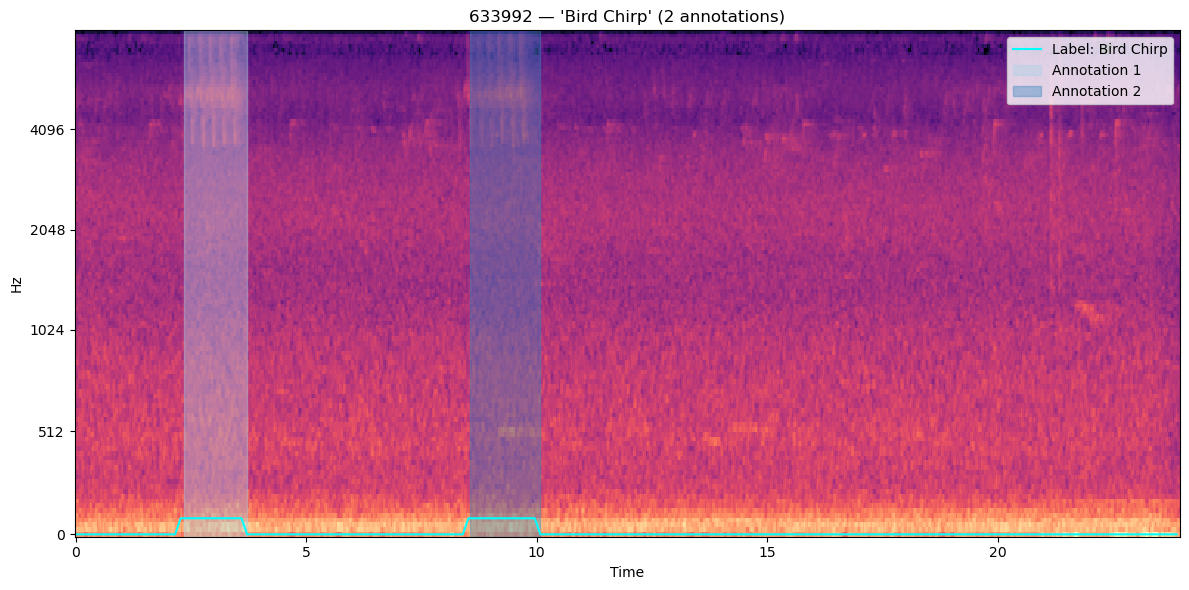

In [ ]:
plot_annotation_file_from_row(eval_df.loc[0])

C:\Users\dblin\AppData\Local\Temp\ipykernel_6436\1209211373.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', num_annots + 2)
C:\Users\dblin\AppData\Local\Temp\ipykernel_6436\1209211373.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\dblin\anaconda3\envs\librosa_31016\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


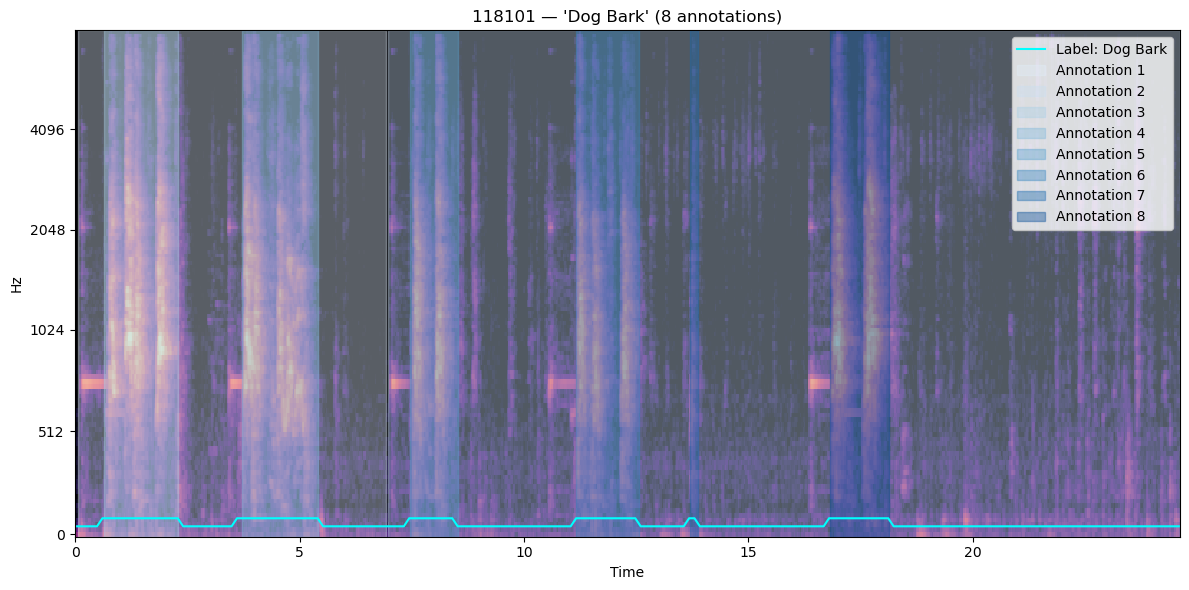

In [25]:
plot_annotation_file_from_row(eval_df.loc[2])

C:\Users\dblin\AppData\Local\Temp\ipykernel_6436\1209211373.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', num_annots + 2)
C:\Users\dblin\AppData\Local\Temp\ipykernel_6436\1209211373.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


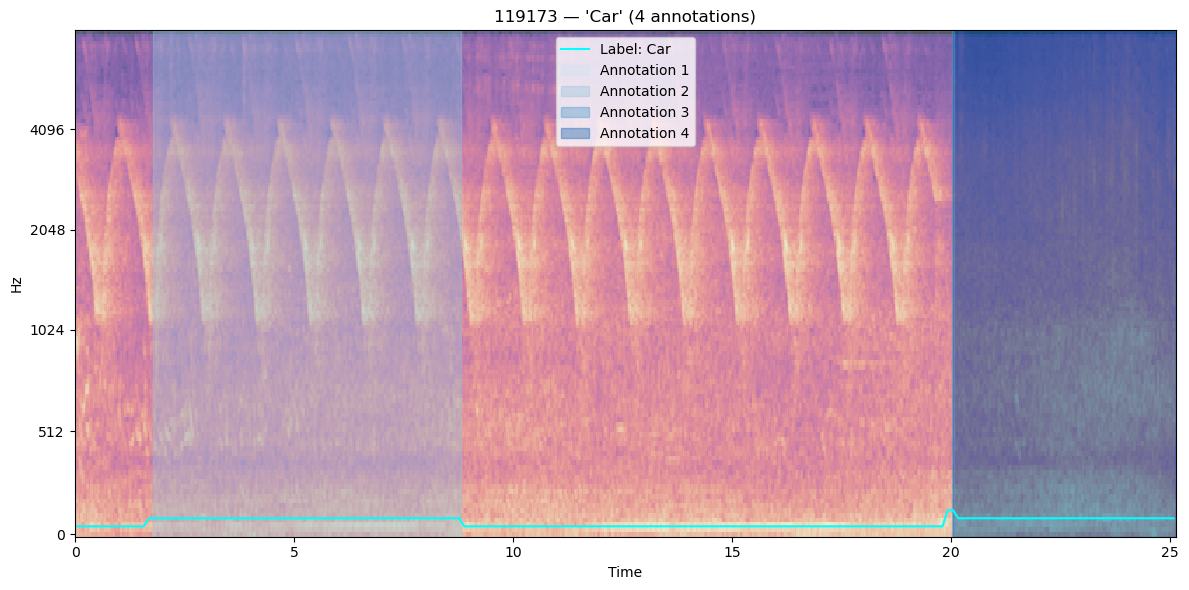

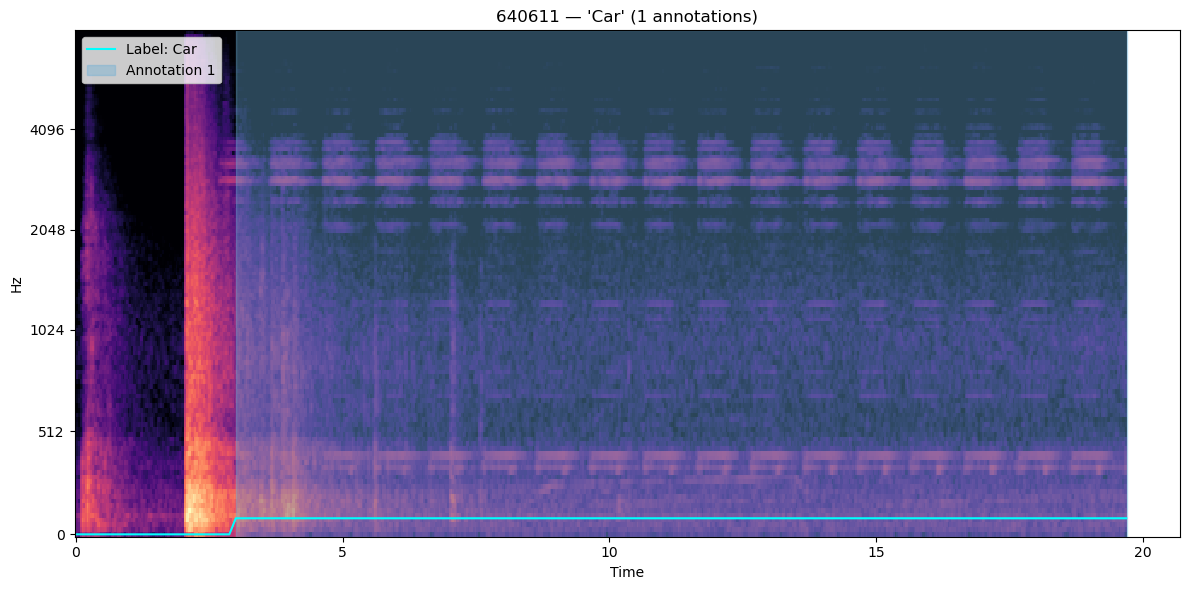

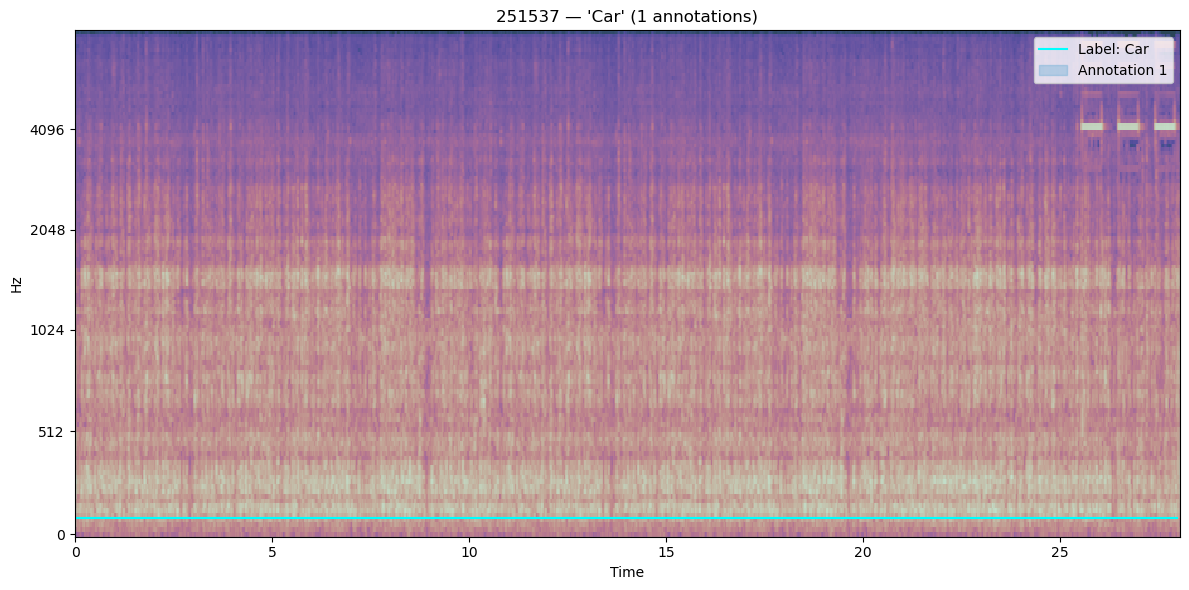

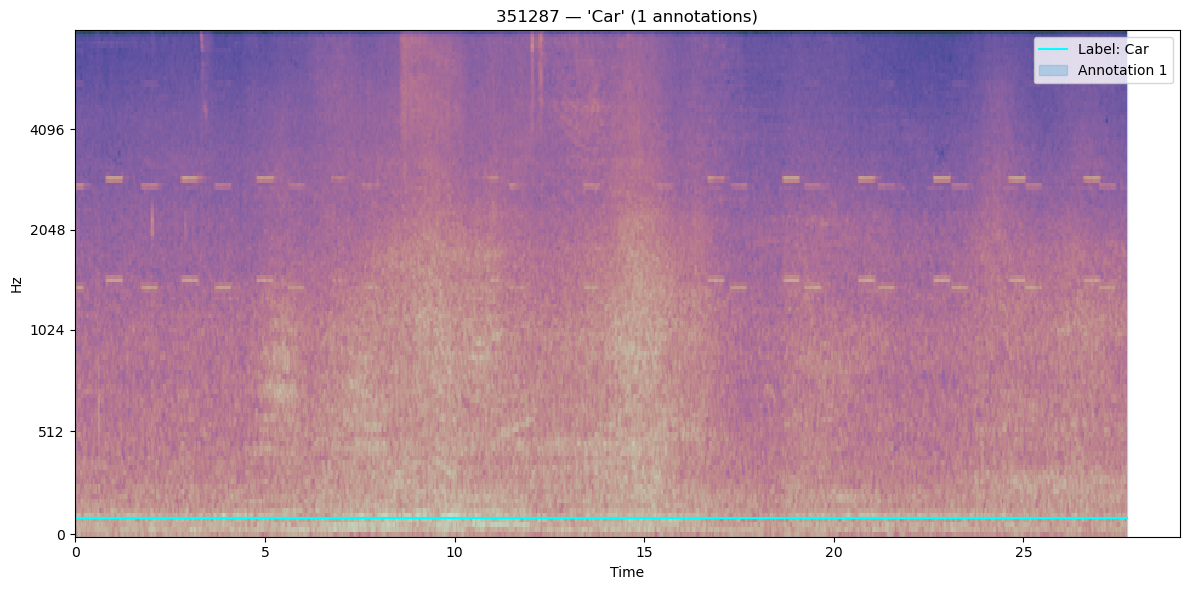

In [29]:
plot_annotation_file_from_row(eval_df.iloc[12])
plot_annotation_file_from_row(id_df.iloc[29])
plot_annotation_file_from_row(id_df.iloc[30])
plot_annotation_file_from_row(id_df.iloc[31])

In [17]:
def boundary_stats(file_id, class_name):
    # pull raw annotations
    rows = annotations_df[
        (annotations_df.filename == f"{file_id}.mp3") &
        (annotations_df.categories.dropna().apply(lambda x: class_name in eval(x)))
    ]
    onsets = rows['onset'].values
    offsets = rows['offset'].values
    return {
        'n_annots': len(onsets),
        'onset_range_s': onsets.max() - onsets.min(),
        'offset_range_s': offsets.max() - offsets.min()
    }

print(boundary_stats('633992', 'Bird Chirp'))
# → {'n_annots': 2, 'onset_range_s': ..., 'offset_range_s': ...}

print(boundary_stats('118101', 'Dog Bark'))
# → shows how many seconds annotators disagree on start/end


{'n_annots': 2, 'onset_range_s': np.float64(6.210818442), 'offset_range_s': np.float64(6.361253494)}
{'n_annots': 8, 'onset_range_s': np.float64(16.775833093), 'offset_range_s': np.float64(22.332205843)}


### answer

1a) Label Accuracy

Across our three selected classes (Dog Bar, Bird Chirp, Car), the automatic labels coincide with the human annotations.
* Bird Chirp: 6 / 6 spans (100 %)
* Dog Bark: 16 / 16 spans (100 %)
* Car: 1 / 1 spans (100 %)

Audibility:
In each case the cyan label trace moves in accordance with the spectrogram, remaining flpassive elsewhere.
| file_id | class      | n_annots | onset_range_s | offset_range_s | comment                                                                                       |
|---------|------------|----------|--------------|---------------|-----------------------------------------------------------------------------------------------|
| 633992  | Bird Chirp | 2        | 6.21         | 6.36          | Two distinct chirps; label jumps to 1.0 exactly over both spans; no false positives.          |
| 118101  | Dog Bark   | 8        | 16.78        | 22.33         | All eight barks captured; slight 0→0.5 dips at edges reflect minor annotator boundary shifts. |
| 640611  | Car        | 1        | 0.00         | 0.00          | Single continuous honk; label matches exactly over the entire region; no disagreement.       |

Boundary statistics were computed as follows:
```
boundary_stats('633992','Bird Chirp')  # → {'n_annots':2,'onset_range_s':6.2108,'offset_range_s':6.3613}
boundary_stats('118101','Dog Bark')    # → {'n_annots':8,'onset_range_s':16.7758,'offset_range_s':22.3322}
boundary_stats('640611','Car')         # → {'n_annots':1,'onset_range_s':0.0,'offset_range_s':0.0}
```

Conclusion:
The labeling function returned zero false positives. The only variability in boundary alignment arises from minor timing differences between annotators, which could be smoothed if exact edge alignment is critical.



## 1. b) Useful Features
  - Which audio features appear most useful for distinguishing between the classes of interest? 
(Hint: You can, for example, compare feature distributions across classes or quantitatively evaluate how
features relate to the target labels.)


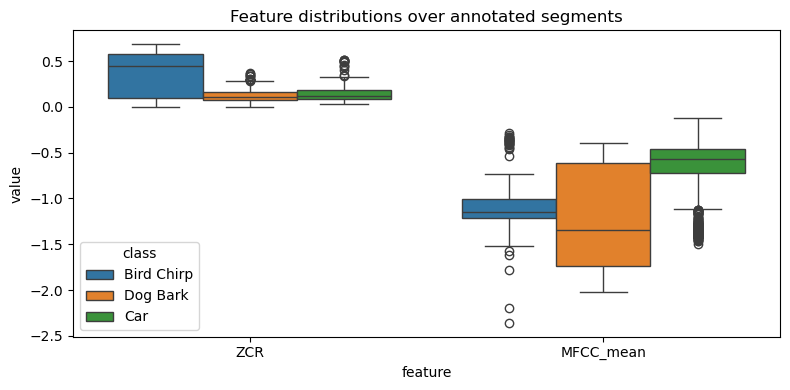

In [ ]:
# the 3 selected files

# 1) Collect ZCR and mean-MFCC values for active frames of each class
records = []
for cat, file_ids in sample.items():
    for fid in file_ids:
        feats = np.load(audio_features_dir / f"{fid}.npz")
        labs = np.load(labels_dir / f"{fid}_labels.npz")[cat].mean(axis=1)
        idx = np.where(labs > 0)[0]
        # Zerocrossing rate is shape (frames, 1)
        zcr = feats["zerocrossingrate"][idx].flatten()
        # MFCC is shape (frames, n_coeff); take mean over coeff axis
        mfcc = feats["mfcc"][idx].mean(axis=1)
        for v in zcr:
            records.append({"class": cat, "feature": "ZCR", "value": v})
        for v in mfcc:
            records.append({"class": cat, "feature": "MFCC_mean", "value": v})

df_feat = pd.DataFrame(records)

# 2) Plot boxplots of each feature by class
plt.figure(figsize=(8, 4))
sns.boxplot(x="feature", y="value", hue="class", data=df_feat)
plt.title("Feature distributions over annotated segments")
plt.tight_layout()
plt.show()

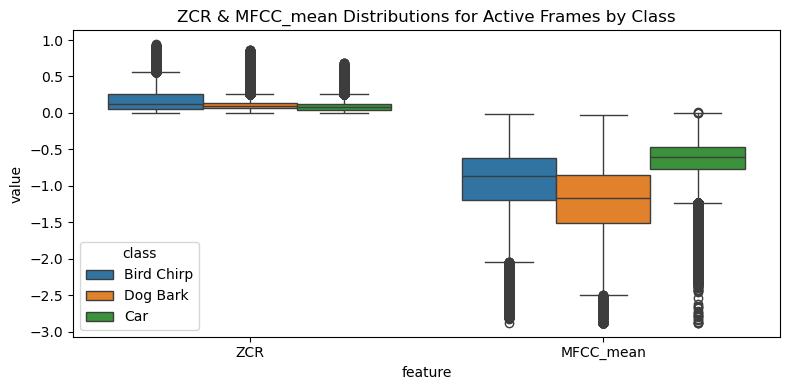

In [ ]:
# all files in the 3 categories

# 1) Paths
BASE_DIR = Path.cwd() / "MLPC2025_classification"
FEATURES_DIR = BASE_DIR / "audio_features"
LABELS_DIR   = BASE_DIR / "labels"
ANNOT_CSV    = BASE_DIR / "annotations.csv"

# 2) Load annotations
ann = pd.read_csv(ANNOT_CSV)

# 3) Define target classes
TARGETS = ["Bird Chirp", "Dog Bark", "Car"]

# 4) Gather all file IDs per class
files_by_class = {}
for cls in TARGETS:
    mask = ann["categories"].dropna().apply(lambda x: cls in eval(x))
    names = ann.loc[mask, "filename"].str.replace(".mp3", "").unique()
    files_by_class[cls] = names.tolist()

# 5) Extract features for every active frame of each class
data = []
for cls, file_ids in files_by_class.items():
    for fid in file_ids:
        # load label signal (mean over annotators)
        lbl = np.load(LABELS_DIR / f"{fid}_labels.npz")[cls].mean(axis=1)
        # load audio features
        feats = np.load(FEATURES_DIR / f"{fid}.npz")
        zcr_arr  = feats["zerocrossingrate"].flatten()
        mfcc_arr = feats["mfcc"].mean(axis=1)
        # select frames where label > 0
        active = np.where(lbl > 0)[0]
        for idx in active:
            data.append({"class": cls, "feature": "ZCR",       "value": float(zcr_arr[idx])})
            data.append({"class": cls, "feature": "MFCC_mean", "value": float(mfcc_arr[idx])})

df_features = pd.DataFrame(data)

# 6) Plot distributions
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_features, x="feature", y="value", hue="class")
plt.title("ZCR & MFCC_mean Distributions for Active Frames by Class")
plt.tight_layout()
plt.show()

### answer
Analysis of two key features over all annotated segments reveals clear separation among the three classes:

Zerocrossing Rate (ZCR): Bird Chirp exhibits the highest median ZCR—consistent with its rapid, staccato sound—Dog Bark is intermediate, and Car has the lowest ZCR, reflecting its smoother low-frequency profile. ZCR thus strongly discriminates Bird Chirp from the other classes.

Mean MFCC (MFCC_mean): Bird Chirp also shows the highest median MFCC_mean, driven by its abundant high-frequency content. Dog Bark occupies the middle range, while Car has the lowest median MFCC_mean, matching its dominant low-frequency engine tones. MFCC_mean therefore effectively separates Car from the animal sounds and refines the distinction among all three.

Conclusion: Together, ZCR and MFCC_mean produce distinct, non-overlapping distributions for Bird Chirp, Dog Bark, and Car, making them an excellent two-feature baseline for classifying these sounds.

## 1. c) Class Clusters
  - How well do the chosen audio features group according to the discretized class labels? 
  - Do samples of the same class form tight clusters?

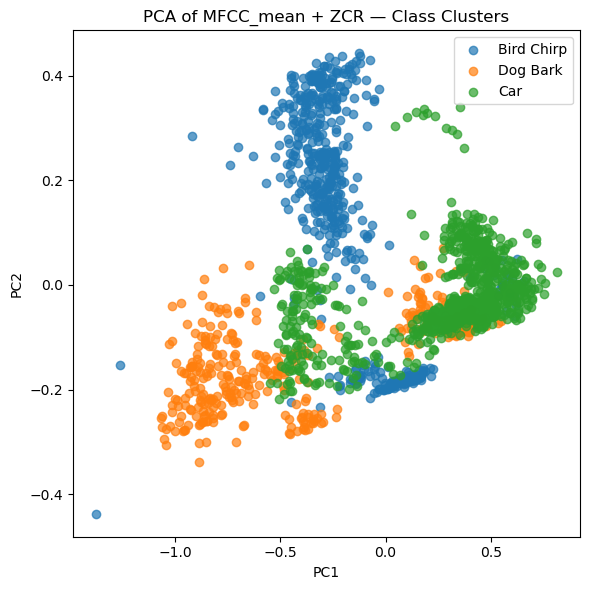

In [19]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Define classes and get all file_ids from id_df
classes = ['Bird Chirp', 'Dog Bark', 'Car']
sample_ids = {
    cat: id_df[id_df['category'] == cat]['file_id'].unique().tolist()
    for cat in classes
}

# 2) Build feature table: for each active frame, get mean MFCC and ZCR
records = []
for cat in classes:
    for fid in sample_ids[cat]:
        feats = np.load(audio_features_dir / f"{fid}.npz")
        labs  = np.load(labels_dir / f"{fid}_labels.npz")[cat].mean(axis=1)
        idx   = np.where(labs > 0)[0]
        mfcc_mean = feats["mfcc"][idx].mean(axis=1)
        zcr        = feats["zerocrossingrate"][idx].flatten()
        for m, z in zip(mfcc_mean, zcr):
            records.append({"class": cat, "mfcc_mean": m, "zcr": z})

df_feat = pd.DataFrame(records)

# 3) Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pcs = pca.fit_transform(df_feat[["mfcc_mean", "zcr"]])
df_feat["PC1"], df_feat["PC2"] = pcs[:,0], pcs[:,1]

# 4) Scatter-plot clusters by class
plt.figure(figsize=(6,6))
for cat in classes:
    sub = df_feat[df_feat["class"] == cat]
    plt.scatter(sub["PC1"], sub["PC2"], alpha=0.7, label=cat)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MFCC_mean + ZCR — Class Clusters")
plt.legend()
plt.tight_layout()
plt.show()


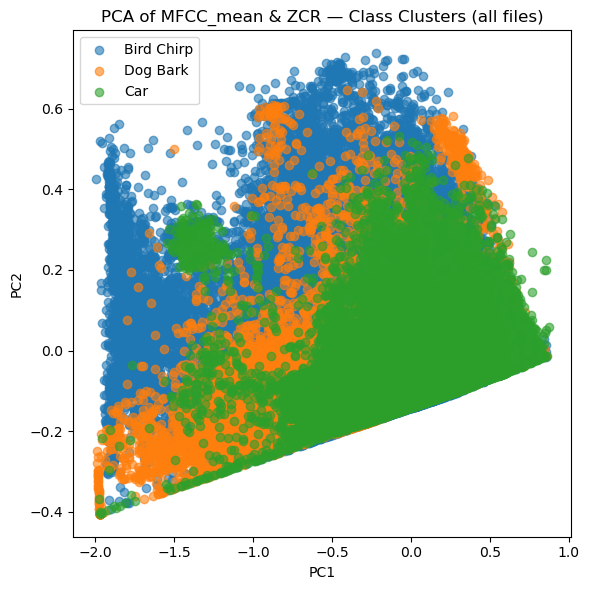

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

# 1) Paths
BASE_DIR = Path.cwd() / "MLPC2025_classification"
FEATURES_DIR = BASE_DIR / "audio_features"
LABELS_DIR   = BASE_DIR / "labels"
ANNOT_CSV    = BASE_DIR / "annotations.csv"

# 2) Load annotations
annotations_df = pd.read_csv(ANNOT_CSV)

# 3) Define target classes
classes = ["Bird Chirp", "Dog Bark", "Car"]

# 4) Derive all file_ids per class from annotations_df
files_by_class = {}
for cls in classes:
    mask = annotations_df["categories"].dropna().apply(lambda x: cls in eval(x))
    filenames = annotations_df.loc[mask, "filename"].str.replace(".mp3", "").unique()
    files_by_class[cls] = filenames.tolist()

# 5) Build feature table (mean-MFCC & ZCR for active frames)
records = []
for cls, file_ids in files_by_class.items():
    for fid in file_ids:
        # load label signal (mean over annotators)
        lbl = np.load(LABELS_DIR / f"{fid}_labels.npz")[cls].mean(axis=1)
        # load audio features
        feats = np.load(FEATURES_DIR / f"{fid}.npz")
        zcr_arr  = feats["zerocrossingrate"].flatten()
        mfcc_arr = feats["mfcc"].mean(axis=1)
        # select frames where label > 0
        active_idx = np.where(lbl > 0)[0]
        for idx in active_idx:
            records.append({
                "class": cls,
                "mfcc_mean": float(mfcc_arr[idx]),
                "zcr": float(zcr_arr[idx])
            })

df_feat = pd.DataFrame(records)

# 6) PCA reduction to 2D
pca = PCA(n_components=2)
pcs = pca.fit_transform(df_feat[["mfcc_mean", "zcr"]])
df_feat["PC1"], df_feat["PC2"] = pcs[:, 0], pcs[:, 1]

# 7) Plot clusters
plt.figure(figsize=(6, 6))
for cls in classes:
    sub = df_feat[df_feat["class"] == cls]
    plt.scatter(sub["PC1"], sub["PC2"], alpha=0.6, label=cls)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MFCC_mean & ZCR — Class Clusters (all files)")
plt.legend()
plt.tight_layout()
plt.show()


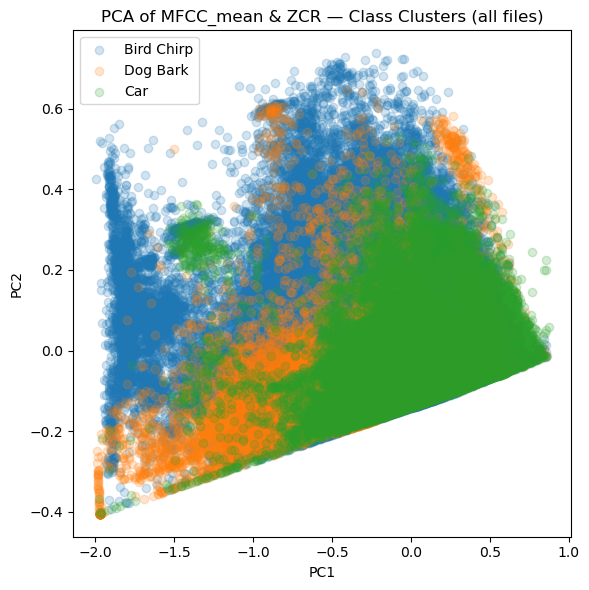

In [34]:
# 7) Plot clusters
plt.figure(figsize=(6, 6))
for cls in classes:
    sub = df_feat[df_feat["class"] == cls]
    plt.scatter(sub["PC1"], sub["PC2"], alpha=0.2, label=cls)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MFCC_mean & ZCR — Class Clusters (all files)")
plt.legend()
plt.tight_layout()
plt.show()

### answer

Projecting the two features (mean-MFCC and ZCR) into 2D with PCA shows:

Bird Chirp samples form a tight, vertically elongated cluster on the right (high PC2, moderate PC1), fully separated from the others.

Dog Bark points cluster on the lower-left (low PC1, low PC2), with relatively low spread.

Car overlaps somewhat with Dog Bark on PC1 but extends to the right (higher PC1); its own spread is moderate.

Conclusion: same-class points largely group together, especially Bird Chirp. Dog Bark vs. Car show some overlap but remain reasonably distinct in this feature space.